In [1]:
import os
import re
import yaml
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- ⚙️ 1. 설정 변수 ---

# 데이터 소스 경로
IMAGE_BASE_DIRS = [
    "../dataset/franka_research3/franka_research3_pose1",
    "../dataset/franka_research3/franka_research3_pose2"
]
JOINT_DATA_PATH = "../dataset/franka_research3/franka_research3_Joint_Angle"

# 최종 동기화 결과가 저장될 경로 및 파일명
OUTPUT_SYNC_CSV_PATH = "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/franka_research3/fr3_matched_joint_angle.csv"

# 동기화 최대 허용 시간 차이 (초 단위)
# 예: 0.05는 50ms를 의미하며, 이보다 시간 차이가 크면 매칭에서 제외됩니다.
MAX_TIME_DIFFERENCE_THRESHOLD = 0.05

# --- 🛠️ 2. 헬퍼 함수 ---

def process_yaml_to_df_records(yaml_path):
    """하나의 YAML 파일을 읽어 데이터 레코드(딕셔너리)의 리스트를 반환합니다."""
    records = []
    with open(yaml_path, 'r') as f:
        try:
            # safe_load_all은 여러 YAML 문서가 '---'로 구분된 경우를 처리합니다.
            all_docs = list(yaml.safe_load_all(f))
        except yaml.YAMLError as e:
            print(f"Error parsing YAML file {yaml_path}: {e}")
            return []

    for doc in all_docs:
        if not doc:
            continue
        
        record = {}
        stamp = doc.get('header', {}).get('stamp', {})
        sec = stamp.get('sec', 0)
        nanosec = stamp.get('nanosec', 0)
        record['timestamp'] = float(f"{sec}.{nanosec:09d}"[:14])

        joint_names = doc.get('name', [])
        positions = doc.get('position', [])
        velocities = doc.get('velocity', [])
        efforts = doc.get('effort', [])

        for i, name in enumerate(joint_names):
            record[f'position_{name}'] = positions[i] if i < len(positions) else np.nan
            record[f'velocity_{name}'] = velocities[i] if i < len(velocities) else np.nan
            record[f'effort_{name}'] = efforts[i] if i < len(efforts) else np.nan
        
        records.append(record)
    return records

def find_image_files(base_dirs):
    """지정된 모든 상위 디렉토리에서 이미지 파일을 재귀적으로 찾습니다."""
    image_files = []
    for base_dir in base_dirs:
        for root, _, files in os.walk(base_dir):
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_files.append(os.path.join(root, f))
    return image_files

def parse_image_timestamp(image_path):
    """이미지 파일명 (형식: zed_SERIAL_cam_TIMESTAMP.jpg)에서 타임스탬프를 float으로 추출합니다."""
    try:
        filename = os.path.basename(image_path)
        # 파일명 형식에 맞춰 유연하게 타임스탬프 부분을 추출합니다.
        parts = filename.replace('.jpg', '').replace('.png', '').replace('.jpeg', '').split('_')
        timestamp_str = parts[-1]
        return float(timestamp_str)
    except (IndexError, ValueError):
        # 타임스탬프 추출 실패 시 None 반환
        return None

# --- 🚀 3. 메인 실행 함수 ---

def create_synchronized_dataset():
    """
    모든 로봇 데이터(YAML)와 이미지 데이터를 로드하고,
    타임스탬프를 기준으로 동기화하여 하나의 CSV 파일로 저장합니다.
    """
    
    # --- 단계 1: 모든 YAML 파일 로드 및 단일 로봇 데이터프레임 생성 ---
    print("--- 단계 1: 모든 로봇 관절 데이터(YAML) 로딩 및 통합 ---")
    all_joint_paths = glob.glob(os.path.join(JOINT_DATA_PATH, "joint_states_*.yaml"))
    
    if not all_joint_paths:
        print(f"❌ 에러: '{JOINT_DATA_PATH}' 경로에 YAML 파일이 없습니다.")
        return

    all_robot_records = []
    for yaml_path in tqdm(all_joint_paths, desc="YAML 파일 처리 중"):
        all_robot_records.extend(process_yaml_to_df_records(yaml_path))
        
    df_robot = pd.DataFrame(all_robot_records)
    df_robot.sort_values('timestamp', inplace=True, ignore_index=True) # 시간순 정렬
    
    print(f"✅ 총 {len(df_robot)}개의 로봇 데이터 포인트를 {len(all_joint_paths)}개 파일로부터 통합했습니다.\n")

    # --- 단계 2: 모든 이미지 파일 경로 스캔 ---
    print("--- 단계 2: 모든 이미지 파일 스캔 ---")
    image_paths = find_image_files(IMAGE_BASE_DIRS)
    print(f"✅ 총 {len(image_paths)}개의 이미지 파일을 찾았습니다.\n")

    # --- 단계 3: 이미지와 로봇 데이터 타임스탬프 기준 동기화 ---
    print("--- 단계 3: 이미지와 로봇 데이터 동기화 ---")
    synchronized_records = []
    robot_timestamps = df_robot['timestamp'].values # 빠른 검색을 위해 numpy 배열로 변환

    for image_path in tqdm(image_paths, desc="이미지 매칭 중"):
        img_ts = parse_image_timestamp(image_path)
        if img_ts is None:
            continue

        # 가장 가까운 타임스탬프의 인덱스 찾기
        time_diffs = np.abs(robot_timestamps - img_ts)
        closest_idx = np.argmin(time_diffs)
        min_time_diff = time_diffs[closest_idx]

        # 시간 차이가 설정된 임계값 이내인지 확인
        if min_time_diff < MAX_TIME_DIFFERENCE_THRESHOLD:
            matching_robot_row = df_robot.iloc[closest_idx]
            
            record = {
                'image_path': image_path,
                'image_timestamp': img_ts,
                'robot_timestamp': matching_robot_row['timestamp'],
                'time_difference_s': min_time_diff
            }
            # 매칭된 로봇 데이터의 모든 열을 레코드에 추가
            record.update(matching_robot_row.to_dict())
            
            synchronized_records.append(record)

    # --- 단계 4: 최종 결과 저장 ---
    if not synchronized_records:
        print("\n❌ 매칭된 데이터가 없습니다. 결과 파일이 생성되지 않았습니다.")
        return
        
    df_sync = pd.DataFrame(synchronized_records)
    # 이미지 타임스탬프 기준으로 최종 정렬
    df_sync.sort_values('image_timestamp', inplace=True, ignore_index=True)
    
    # 출력 폴더 생성
    output_dir = os.path.dirname(OUTPUT_SYNC_CSV_PATH)
    os.makedirs(output_dir, exist_ok=True)
    
    df_sync.to_csv(OUTPUT_SYNC_CSV_PATH, index=False)
    
    print("\n\n--- 🎉 동기화 완료 ---")
    print(f"✅ 총 {len(df_sync)}개의 이미지-로봇 쌍이 성공적으로 동기화되었습니다.")
    print(f"✅ 결과 저장 경로: {OUTPUT_SYNC_CSV_PATH}")
    print("\n--- 동기화 데이터 샘플 ---")
    # 실제 존재하는 컬럼명으로 샘플 출력 수정
    sample_cols = ['image_path', 'time_difference_s', 'position_fr3_joint1', 'position_fr3_joint2', 'position_fr3_joint3']
    # df_sync에 해당 컬럼이 있는지 확인 후 출력
    display_cols = [col for col in sample_cols if col in df_sync.columns]
    print(df_sync[display_cols].head())


if __name__ == '__main__':
    create_synchronized_dataset()

--- 단계 1: 모든 로봇 관절 데이터(YAML) 로딩 및 통합 ---


YAML 파일 처리 중: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


✅ 총 22737개의 로봇 데이터 포인트를 20개 파일로부터 통합했습니다.

--- 단계 2: 모든 이미지 파일 스캔 ---
✅ 총 17387개의 이미지 파일을 찾았습니다.

--- 단계 3: 이미지와 로봇 데이터 동기화 ---


이미지 매칭 중: 100%|██████████| 17387/17387 [00:01<00:00, 11812.85it/s]




--- 🎉 동기화 완료 ---
✅ 총 16158개의 이미지-로봇 쌍이 성공적으로 동기화되었습니다.
✅ 결과 저장 경로: /home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/franka_research3/fr3_matched_joint_angle.csv

--- 동기화 데이터 샘플 ---
                                          image_path  time_difference_s  \
0  ../dataset/franka_research3/franka_research3_p...              0.004   
1  ../dataset/franka_research3/franka_research3_p...              0.004   
2  ../dataset/franka_research3/franka_research3_p...              0.015   
3  ../dataset/franka_research3/franka_research3_p...              0.015   
4  ../dataset/franka_research3/franka_research3_p...              0.001   

   position_fr3_joint1  position_fr3_joint2  position_fr3_joint3  
0             0.643797            -0.109007             0.215009  
1             0.643797            -0.109007             0.215009  
2             0.652528            -0.107551             0.204395  
3             0.652528            -0.107551             0.204395  
4         


--- [DEBUG] Checking CSV Columns ---
Columns found in '../dataset/franka_research3/fr3_matched_joint_angle.csv':
['image_path', 'image_timestamp', 'robot_timestamp', 'time_difference_s', 'timestamp', 'position_fr3_joint1', 'velocity_fr3_joint1', 'effort_fr3_joint1', 'position_fr3_joint2', 'velocity_fr3_joint2', 'effort_fr3_joint2', 'position_fr3_joint3', 'velocity_fr3_joint3', 'effort_fr3_joint3', 'position_fr3_joint4', 'velocity_fr3_joint4', 'effort_fr3_joint4', 'position_fr3_joint5', 'velocity_fr3_joint5', 'effort_fr3_joint5', 'position_fr3_joint6', 'velocity_fr3_joint6', 'effort_fr3_joint6', 'position_fr3_joint7', 'velocity_fr3_joint7', 'effort_fr3_joint7', 'position_fr3_finger_joint1', 'velocity_fr3_finger_joint1', 'effort_fr3_finger_joint1', 'position_fr3_finger_joint2', 'velocity_fr3_finger_joint2', 'effort_fr3_finger_joint2']
-------------------------------------

--- Finding a representative image for each of the 8 view/cam combinations ---
✅ Found match for [view1/left]: zed_

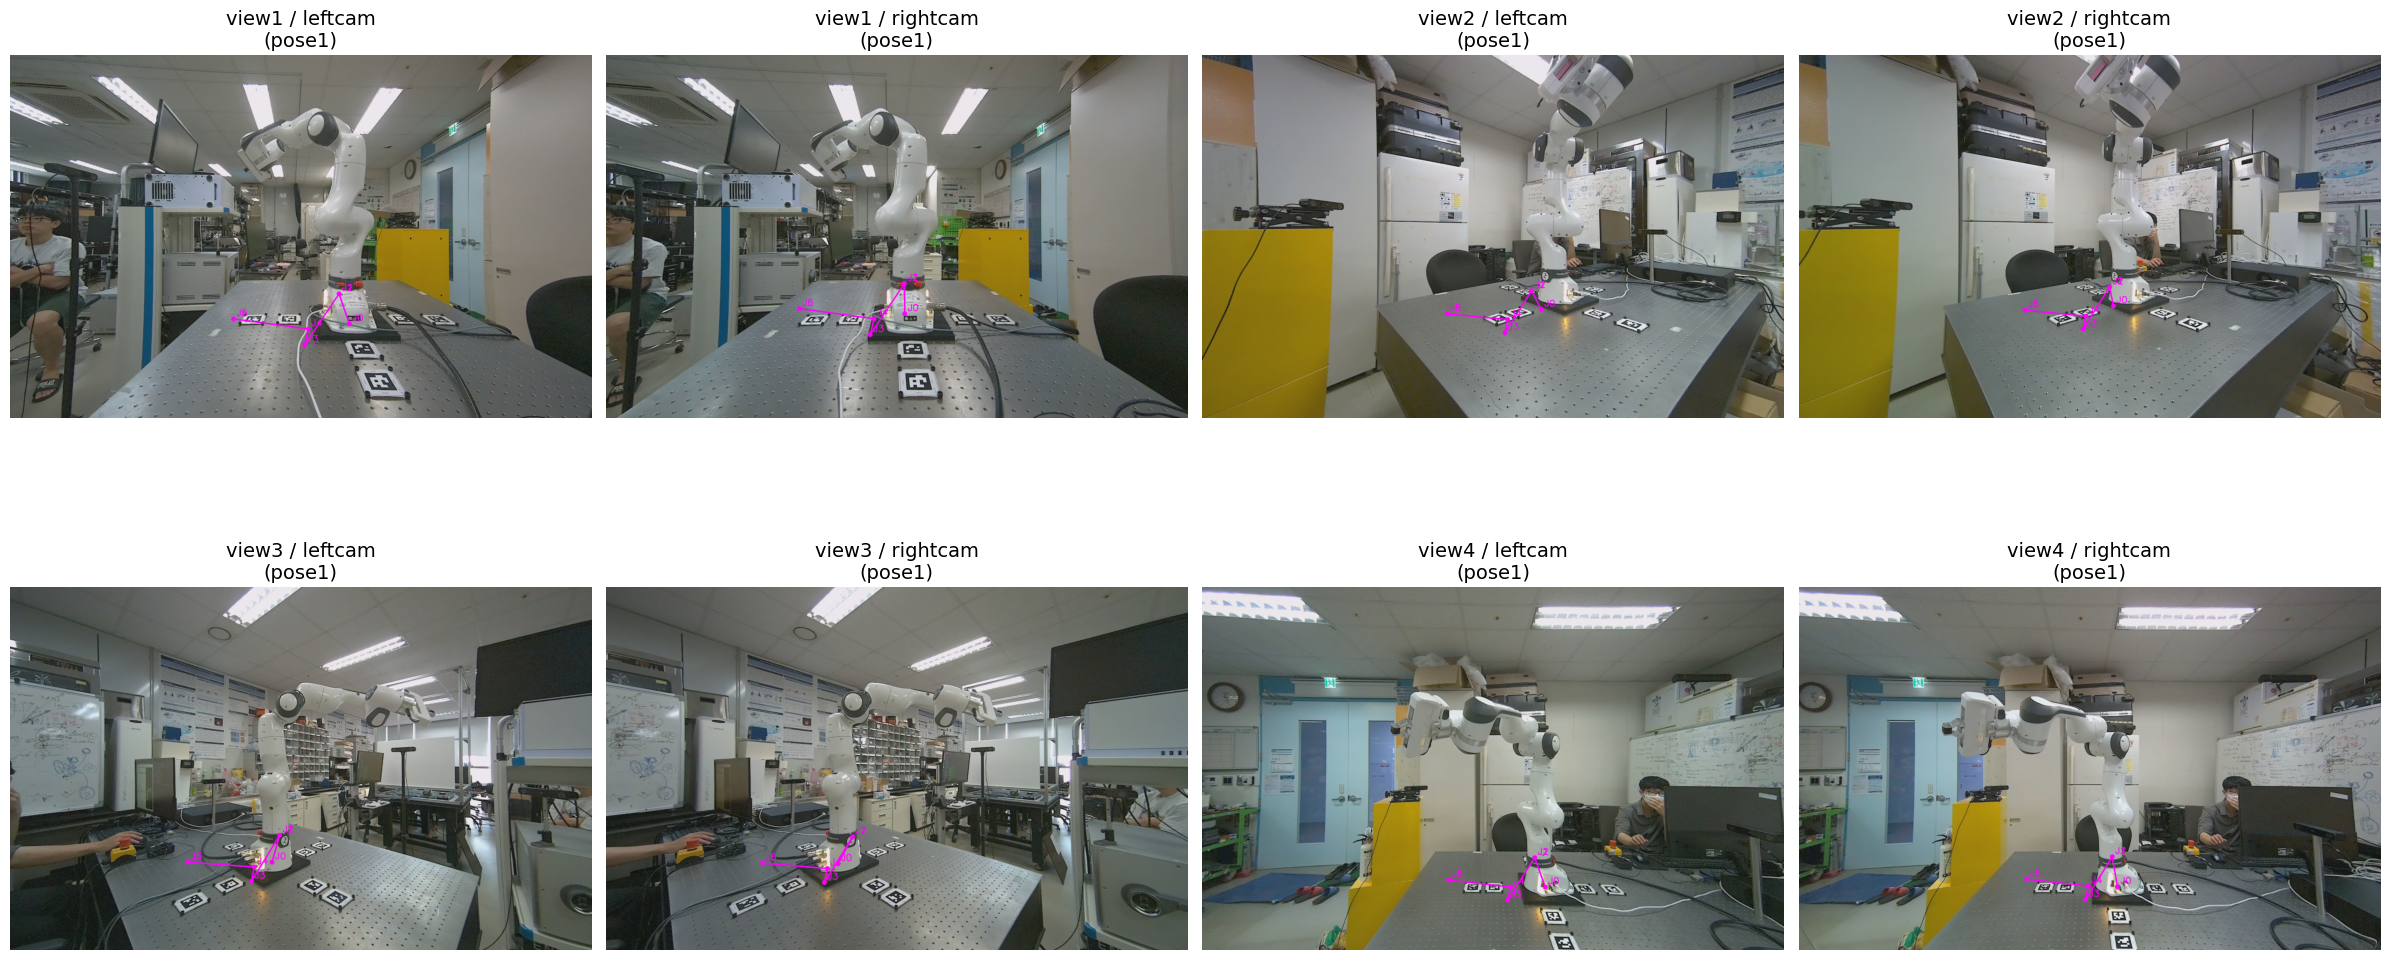

In [25]:
import os
import cv2
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import traceback # ✨ ADDED: For detailed error reporting

# Note: Korean font setup removed as we are now using English for plot titles.

# ---------------------- Helper Functions ----------------------
# (Helper functions are the same as before, so they are omitted for brevity)
# ...
def get_dh_matrix(a, d, alpha, theta):
    """Calculates the transformation matrix from DH parameters."""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta) # Assumes theta is input in degrees
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

def angle_to_joint_coordinate(joint_angles, selected_view):
    """Converts 7 joint angles to 3D coordinates using forward kinematics."""
    # DH Parameters for Franka Research 3 (FR3) robot (meters and degrees)
    # IMPORTANT: Verify these parameters match your robot.
    fr3_dh_parameters = [
        {'a': 0,      'd': 0.333, 'alpha':   0, 'theta_offset': 0}, #1
        {'a': 0,      'd': 0,     'alpha': -90, 'theta_offset': 0}, #2
        {'a': 0,      'd': 0.316, 'alpha':  90, 'theta_offset': 0}, #3
        {'a': 0.0825, 'd': 0,     'alpha':  90, 'theta_offset': 0}, #4
        {'a': -0.0825,'d': 0.384, 'alpha': -90, 'theta_offset': 0}, #5
        {'a': 0,      'd': 0,     'alpha':  90, 'theta_offset': 0}, #6
        {'a': 0.088,  'd': 0,     'alpha':  90, 'theta_offset': 0}, #7 
        {'a': 0,      'd': 0.107, 'alpha':   0, 'theta_offset': 0}  # flanger
    ]
    
    # Rotational correction for the robot base depending on the camera view
    view_rotations = {
        'view1': R.from_euler('zyx', [0, 0, 0], degrees=True),      # Front (reference)
        'view4': R.from_euler('zyx', [0, 0, 0], degrees=True),  # Top
        'view3': R.from_euler('zyx', [0, 0, 0], degrees=True),   # Left
        'view2': R.from_euler('zyx', [0, 0, 0], degrees=True)     # Right
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (base) position
    
    base_point = np.array([[0], [0], [0], [1]])
    for i, angle_rad in enumerate(joint_angles):
        params = fr3_dh_parameters[i]
        theta_deg = math.degrees(angle_rad) + params['theta_offset']
        
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta_deg)
        T_cumulative = T_cumulative @ T_i
        
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
        
    return np.array(joint_coords_3d, dtype=np.float32)

def project_to_pixel(coords_3d, aruco_result, camera_matrix, dist_coeffs):
    """Projects 3D coordinates onto the 2D image plane."""
    Rvec = np.array([
        math.radians(aruco_result['rvec_x']),
        math.radians(aruco_result['rvec_y']),
        math.radians(aruco_result['rvec_z'])
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    pixel_coords, _ = cv2.projectPoints(
        coords_3d, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    return pixel_coords.reshape(-1, 2)

def visualize_single_image(ax, image_path, joint_angles, aruco_result, calib_data):
    """Draws the image and projected joints onto a single subplot axis."""
    image = cv2.imread(image_path)
    if image is None:
        ax.set_title(f"Image not found:\n{os.path.basename(image_path)}", color='red')
        ax.axis("off")
        return
        
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    camera_matrix = np.array(calib_data["camera_matrix"], dtype=np.float32)
    dist_coeffs = np.array(calib_data["distortion_coeffs"], dtype=np.float32)
    
    undistorted_img = cv2.undistort(image_rgb, camera_matrix, dist_coeffs)

    view_name = aruco_result['view']
    joint_coords_3d = angle_to_joint_coordinate(joint_angles, view_name)
    pixel_coords = project_to_pixel(joint_coords_3d, aruco_result, camera_matrix, dist_coeffs)

    font = cv2.FONT_HERSHEY_SIMPLEX
    for idx, (x, y) in enumerate(pixel_coords.astype(int)):
        cv2.circle(undistorted_img, (x, y), 8, (255, 0, 255), -1) # Magenta
        cv2.putText(undistorted_img, f"J{idx}", (x + 10, y - 10), font, 1.0, (255, 0, 255), 2)
        
        if idx > 0:
            prev_x, prev_y = pixel_coords[idx-1].astype(int)
            cv2.line(undistorted_img, (prev_x, prev_y), (x, y), (255, 0, 255), 3)

    pose_name = "pose1" if "pose1" in image_path else "pose2"
    ax.imshow(undistorted_img)
    ax.axis("off")
    ax.set_title(f"{aruco_result['view']} / {aruco_result['cam']}\n({pose_name})", fontsize=14)

# ---------------------- 🚀 Main Execution ----------------------

# 1. Configure paths
SYNC_CSV_PATH = "../dataset/franka_research3/fr3_matched_joint_angle.csv"
POSE1_ARUCO_JSON_PATH = "../dataset/franka_research3/pose1_aruco_pose_summary.json"
POSE2_ARUCO_JSON_PATH = "../dataset/franka_research3/pose2_aruco_pose_summary.json"
CALIB_DIR = "../dataset/franka_research3/Calib_cam_from_conf"

serial_to_view = {
    '41182735': "view1", '49429257': "view2",
    '44377151': "view3", '49045152': "view4"
}

# 2. Load data
try:
    df_sync = pd.read_csv(SYNC_CSV_PATH)
    with open(POSE1_ARUCO_JSON_PATH, 'r') as f:
        pose1_aruco_results = json.load(f)
    with open(POSE2_ARUCO_JSON_PATH, 'r') as f:
        pose2_aruco_results = json.load(f)
except FileNotFoundError as e:
    print(f"❌ Error: A required file was not found - {e}")
    exit()

# ✨ ADDED: Print the actual column names from the CSV file for debugging
print("\n--- [DEBUG] Checking CSV Columns ---")
print(f"Columns found in '{SYNC_CSV_PATH}':")
print(df_sync.columns.tolist())
print("-------------------------------------\n")


# 3. Find one representative image for each of the 8 view/cam combinations
views_to_plot = ['view1', 'view2', 'view3', 'view4']
cams_to_plot = ['left', 'right']
selected_data = []

print("--- Finding a representative image for each of the 8 view/cam combinations ---")
# ... (Finding logic is the same) ...
for view in views_to_plot:
    for cam in cams_to_plot:
        found = False
        for _, row in df_sync.iterrows():
            try:
                img_name = os.path.basename(row['image_path'])
                parts = img_name.split('_')
                row_view = serial_to_view[parts[1]]
                row_cam = parts[2]
                
                if row_view == view and row_cam == cam:
                    selected_data.append(row)
                    print(f"✅ Found match for [{view}/{cam}]: {img_name}")
                    found = True
                    break
            except (KeyError, IndexError):
                continue
        if not found:
            print(f"⚠️ Could not find a matching image for [{view}/{cam}] in the CSV.")


# 4. Create 2x4 subplots and run visualization
if selected_data:
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flatten()

    for i, row in enumerate(selected_data):
        image_path = row['image_path']
        
        # This part is correct as the column names exist in your CSV
        joint_angles = [row[f'position_fr3_joint{j}'] for j in range(1, 7)]
        
        img_name = os.path.basename(image_path)
        parts = img_name.split('_')
        serial_str = parts[1]
        cam_str = parts[2] # This will be 'left' or 'right'
        view_str = serial_to_view[serial_str]
        
        # Select the correct ArUco data based on the image path
        current_aruco_data = None
        pose_name = ""
        if 'pose1' in image_path:
            current_aruco_data = pose1_aruco_results
            pose_name = "pose1"
        elif 'pose2' in image_path:
            current_aruco_data = pose2_aruco_results
            pose_name = "pose2"
        else:
            axes[i].set_title(f"[{view_str}/{cam_str}]\nPose info missing in path", color='orange')
            axes[i].axis("off")
            continue
        
        print(f"--> Searching for ArUco data for [{view_str}/{cam_str}] in '{pose_name}' JSON file...")
        try:
            # ✨ FIX 1: Find ArUco data by adding 'cam' to the string ('left' -> 'leftcam')
            aruco_result = next(item for item in current_aruco_data if item['view'] == view_str and item['cam'] == (cam_str + 'cam'))
            
            # ✨ FIX 2: Find the calibration file by also adding 'cam' to the string
            calib_path = os.path.join(CALIB_DIR, f"{view_str}_{serial_str}_{cam_str + 'cam'}_calib.json")
            
            with open(calib_path, 'r') as f:
                calib_data = json.load(f)

            # Call the visualization function
            visualize_single_image(axes[i], image_path, joint_angles, aruco_result, calib_data)

        except StopIteration:
            # This error will no longer occur with the fix above
            axes[i].set_title(f"[{view_str}/{cam_str}]\nArUco Data Not Found", color='red')
            axes[i].axis("off")
        except FileNotFoundError:
            # This error will no longer occur with the fix above
            axes[i].set_title(f"[{view_str}/{cam_str}]\nCalibration File Not Found", color='red')
            axes[i].axis("off")
        except Exception as e:
            # Catch any other unexpected errors
            print(f"\n❌ An unexpected error occurred while processing {image_path}:")
            print(f"   Error Type: {type(e).__name__}")
            print(f"   Error Details: {e}")
            traceback.print_exc()
            axes[i].set_title(f"[{view_str}/{cam_str}]\nERROR", color='purple')
            axes[i].axis("off")


    # Turn off any unused subplots
    for j in range(len(selected_data), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("\n❌ No data was selected for visualization. Please check your CSV file and paths.")
